# Google requires you to log in to use this notebook.
This notebook is the variation of the one found at :
https://github.com/juglab/n2v

It can be used to 
- Load images from google drive
- Train a model for Noise2Void
- Batch process a folder of images using the model that has been generated

The N2V article can found at:
https://arxiv.org/abs/1811.10980


# Noise2Void - 2D Example 

In [0]:
import tensorflow as tf
print(tf.__version__)

1.14.0-rc1


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Specifically needed for Google Colab: 
# noise2void needs to be installed every time!
!pip install n2v

In [0]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible

# Training Data Preparation

For training we load __one__ set of low-SNR images and use the <code>N2V_DataGenerator</code> to extract training <code>X</code> and validation <code>X_val</code> patches.

In [0]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [0]:
# We load all the '.tif' files from the 'data' directory.
# If you want to load other types of files see the RGB example.
# The function will return a list of images (numpy arrays).
imgs = datagen.load_imgs_from_directory(directory = "gdrive/My Drive/NOIse2VOID/FA training")

# Let's look at the shape of the images.
print(imgs[0].shape,imgs[1].shape)
# The function automatically added two extra dimensions to the images:
# One at the beginning, is used to hold a potential stack of images such as a movie.
# One at the end, represents channels.

(1, 512, 512, 1) (1, 512, 512, 1)


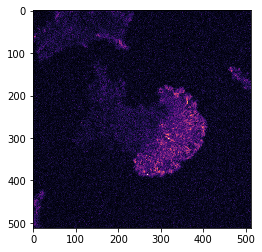

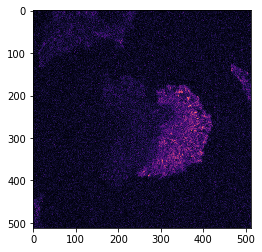

In [0]:
# Lets' look at the images.
# We have to remove the added extra dimensions to display them as 2D images.
plt.imshow(imgs[0][0,...,0], cmap='magma')
plt.show()

plt.imshow(imgs[1][0,...,0], cmap='magma')
plt.show()

In [0]:
# We will use the first image to extract training patches and store them in 'X'
X = datagen.generate_patches_from_list(imgs[:1], shape=(96,96))

# We will use the second image to extract validation patches.
X_val = datagen.generate_patches_from_list(imgs[1:], shape=(96,96))

# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches would also allow us to split them into a training and validation set 
# per image. This might be an interesting alternative to the split we performed above.

Generated patches: (200, 96, 96, 1)
Generated patches: (200, 96, 96, 1)


In [0]:
# Just in case you don't know how to access the docstring of a method:
datagen.generate_patches_from_list?

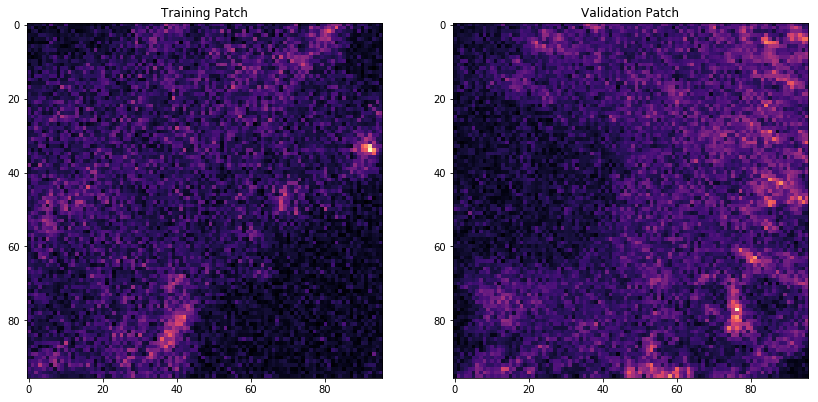

In [0]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='magma')
plt.title('Validation Patch');

# Configure

Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 1.6% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 64 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64).  

<font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 10 and <code>train_steps_per_epoch</code> to only 10. <br>For better results we suggest values of 100, and a few dozen, respectively.

In [0]:

# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=100,train_epochs=50, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=1.6, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'axes': 'YXC',
 'batch_norm': True,
 'mean': '1087.2743',
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'n2v_patch_shape': (64, 64),
 'n2v_perc_pix': 1.6,
 'n_channel_in': 1,
 'n_channel_out': 1,
 'n_dim': 2,
 'std': '544.5557',
 'train_batch_size': 128,
 'train_checkpoint': 'weights_best.h5',
 'train_epochs': 50,
 'train_learning_rate': 0.0004,
 'train_loss': 'mse',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'train_steps_per_epoch': 100,
 'train_tensorboard': True,
 'unet_input_shape': (None, None, 1),
 'unet_kern_size': 3,
 'unet_last_activation': 'linear',
 'unet_n_depth': 2,
 'unet_n_first': 32,
 'unet_residual': False}

In [0]:
# a name used to identify the model
model_name = 'n2v_2DFA'
# the base directory in which our model will live
basedir = 'gdrive/My Drive/NOIse2VOID/model'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

/usr/local/lib/python3.6/dist-packages/csbdeep/models/care_standard.py:139: UserWarning: output path for model already exists, files may be overwritten: /content/gdrive/My Drive/NOIse2VOID/model/n2v_2DFA
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


# Training

Training the model will likely take some time. 

In [0]:
# We are ready to start training now.
history = model.train(X, X_val)

Epoch 1/50
100/100 [==============================] - 78s 777ms/step - loss: 0.3793 - n2v_mse: 0.3793 - n2v_abs: 0.4311 - val_loss: 0.2948 - val_n2v_mse: 0.2948 - val_n2v_abs: 0.4049
Epoch 2/50
100/100 [==============================] - 75s 745ms/step - loss: 0.2870 - n2v_mse: 0.2870 - n2v_abs: 0.3926 - val_loss: 0.2829 - val_n2v_mse: 0.2829 - val_n2v_abs: 0.3960
Epoch 3/50
100/100 [==============================] - 75s 753ms/step - loss: 0.2847 - n2v_mse: 0.2847 - n2v_abs: 0.3909 - val_loss: 0.2783 - val_n2v_mse: 0.2783 - val_n2v_abs: 0.3920
Epoch 4/50
100/100 [==============================] - 77s 775ms/step - loss: 0.2791 - n2v_mse: 0.2791 - n2v_abs: 0.3888 - val_loss: 0.2764 - val_n2v_mse: 0.2764 - val_n2v_abs: 0.3902
Epoch 5/50
100/100 [==============================] - 76s 757ms/step - loss: 0.2792 - n2v_mse: 0.2792 - n2v_abs: 0.3887 - val_loss: 0.2778 - val_n2v_mse: 0.2778 - val_n2v_abs: 0.3922
Epoch 6/50
100/100 [==============================] - 79s 787ms/step - loss: 0.2781 -

### After training, lets plot training and validation loss.

In [0]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Prediction
Here we will simply use the same data as during training and denoise it using our network.

In [0]:
# We load the data we want to process.
input_train = imread('gdrive/My Drive/NOIse2VOID/FA training/train.tif')

# Here we process the data.
# The parameter 'n_tiles' can be used if images are to big for the GPU memory.
# If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
# This can take longer.
pred_train = model.predict(input_train, axes='YX', n_tiles=(2,1))

# We load and process the data we previously used for validation.
input_val = imread('gdrive/My Drive/NOIse2VOID/FA training/validation.tif')
pred_val = model.predict(input_val, axes='YX')

### Show results on training data...

In [0]:
# Let's look at the results.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(input_train[:1500:,:1500],cmap="magma")
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred_train[:1500,:1500],cmap="magma")
plt.title('Prediction');

### Show results on validation data...

In [0]:
# Let's look at the results.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(input_val,cmap="magma")
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred_val,cmap="magma")
plt.title('Prediction');

In [0]:
save_tiff_imagej_compatible('gdrive/My Drive/NOIse2VOID/model/pred_train.tif', pred_train, axes='YX')
save_tiff_imagej_compatible('gdrive/My Drive/NOIse2VOID/model/pred_validation.tif', pred_val, axes='YX')

## Export Model to be Used with CSBDeep Fiji Plugins and KNIME Workflows
See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

_Note:_ in Google Colab you can find the saved file in the file-browsing panel on the left. There you can also download trained models, saved, models, weights, etc.

In [0]:
model.export_TF()

# Process other images !

This part allow to batch process images using the model that has just been generated

In [0]:
from pathlib import Path
import os
from tifffile import imread

# Getting the current work directory (cwd)
thisdir = Path("gdrive/My Drive/NOIse2VOID/totrain")
outputdir = Path("gdrive/My Drive/NOIse2VOID/out")



suffix = '.tif'



# r=root, d=directories, f = files
for r, d, f in os.walk(thisdir):
    for file in f:
        if ".tif" in file:
            print(os.path.join(r, file))

for r, d, f in os.walk(thisdir):
  for file in f:
    base_filename = os.path.basename(file)
    input_train = imread(os.path.join(r, file))
    pred_train = model.predict(input_train, axes='YX', n_tiles=(2,1))
    save_tiff_imagej_compatible(os.path.join(outputdir, base_filename + suffix), pred_train, axes='YX')         


## Save Results

_Note:_ in Google Colab you can find the saved file in the file-browsing panel on the left. There you can also download trained models, saved, models, weights, etc.